In [37]:
import pandas as pd
import matplotlib.pyplot as plt

#data = pd.read_csv('logs/bo_runs_data_pressureswing_Vext_densB.csv')
#doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vext_densB.csv')

#data = pd.read_csv('logs/bo_runs_data_pressureswing_Vext_addfeatchempT.csv')
#doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vext_addfeatchempT.csv')

data = pd.read_csv('logs/bo_runs_data_pressureswing_Vext_addfeatchempT_densB.csv')
doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vext_addfeatchempT_densB.csv')

#data = pd.read_csv('logs/bo_runs_data_pressureswing_Vextchem_addfeatpT_densB.csv')
#doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vextchem_addfeatpT_densB.csv')

#data = pd.read_csv('logs/bo_runs_data_pressureswing_Vextchem_densB.csv')
#doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vextchem_densB.csv')


In [38]:
counts = data['found_global_best'].value_counts()
print(counts)

found_global_best
True     216
False     97
Name: count, dtype: int64


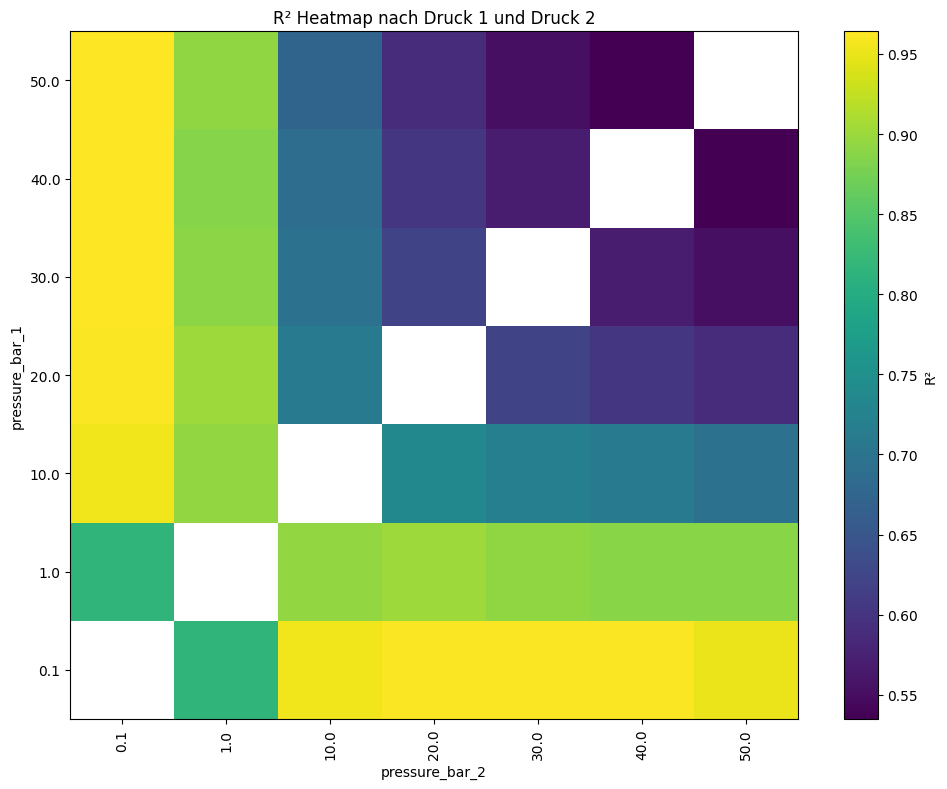

In [39]:

heatmap_data = doto.pivot_table(
    index="pressure_bar_1",
    columns="pressure_bar_2",
    values="r2",
    aggfunc="mean"        # falls mehrere Werte pro Kombination existieren
)

# === Heatmap plotten ===
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', origin='lower')
plt.colorbar(label='R²')

plt.title("R² Heatmap nach Druck 1 und Druck 2")
plt.xlabel("pressure_bar_2")
plt.ylabel("pressure_bar_1")

# Achsenbeschriftungen mit den tatsächlichen Druckwerten
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)

plt.tight_layout()
plt.show()

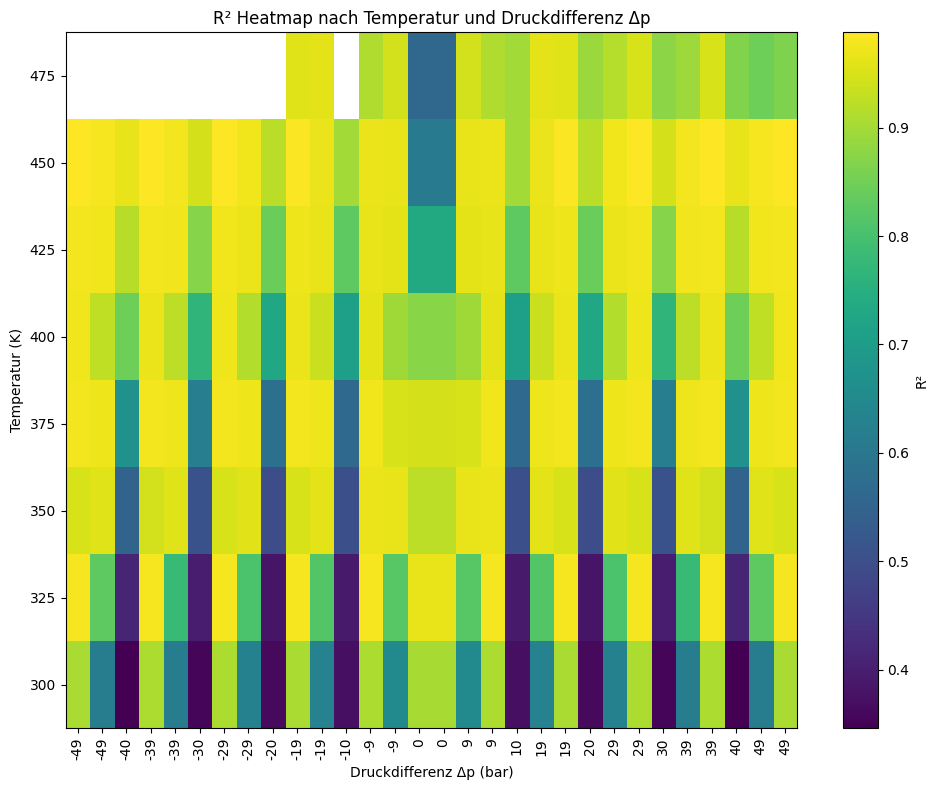

In [40]:
doto["delta_p"] = doto["pressure_bar_2"] - doto["pressure_bar_1"]

# --- Pivot-Tabelle: Temperatur vs Δp ---
heatmap_data = doto.pivot_table(
    index="temperature_kelvin_1",   # Y-Achse
    columns="delta_p",            # X-Achse
    values="r2",                  # Farbe repräsentiert R²
    aggfunc="mean"                # Mittelwert, falls mehrere Kombinationen
)

# --- Sortierung (optional, für saubere Achsen) ---
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# --- Plot ---
plt.figure(figsize=(10, 8))
im = plt.imshow(heatmap_data, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(im, label="R²")

plt.title("R² Heatmap nach Temperatur und Druckdifferenz Δp")
plt.xlabel("Druckdifferenz Δp (bar)")
plt.ylabel("Temperatur (K)")

# Achsenbeschriftungen mit tatsächlichen Werten
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns.astype(int), rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index.astype(int))

plt.tight_layout()
plt.show()